In [1]:
from pathlib import Path
import numpy as np
import IPython.display as ipd
import librosa
from simple_mp.simple import simple_fast
from tqdm import tqdm

root = Path("../data")
motif = root / "motif/train_short_audio"

data = []
species = []
audio = []
for path in tqdm(motif.glob("**/motif.cens.*.npy")):
    data.append(np.load(path))
    species.append(path.parent.parent.name)
    audio.append(path.as_posix().replace(".cens", "").replace(".npy", ".ogg"))

1002it [00:00, 1966.27it/s]


In [2]:
len(audio)

1002

In [19]:
sample_domain = np.random.choice(np.arange(len(data)), 200)
sample_domain

array([446,   9, 668, 572, 370,  62, 678, 351, 211, 170, 383, 330, 198,
       500, 968, 586, 109, 286, 957, 471, 150, 759, 355, 715, 240, 988,
       230, 226, 458, 405, 920, 341, 203, 715, 908, 979, 919, 759, 492,
        54,   1, 728, 362, 834, 801, 548, 250,  62, 515, 360, 993, 670,
       443,  40, 436, 783, 391, 923, 811, 153, 891, 197, 331, 961, 153,
       486, 761, 294, 692, 123, 822, 664, 905, 663, 855, 591, 429, 416,
       815, 421, 500, 512, 574, 441,  54,  60, 885, 292, 730, 230, 347,
       160, 309, 318, 915, 185, 308, 270, 781, 187, 792, 128, 951, 156,
       183, 612, 422, 502, 153, 355, 711, 591, 557, 985, 102, 808, 116,
       180, 296, 173, 187, 649, 197, 393, 454, 611, 235, 258, 247, 212,
       436, 148, 293,  45, 384, 124, 605, 556, 278, 427, 651, 634,  54,
       382, 900, 296, 802, 330, 479, 123, 667, 326, 876, 614, 635, 579,
       898, 249, 448, 264, 496, 236, 815, 236, 274,  39, 165, 894, 194,
        77, 457, 660,   8, 243, 590, 501, 697, 459,  67, 607, 60

In [20]:
sample_data = [data[i] for i in sample_domain]
sample_audio = [audio[i] for i in sample_domain]
sample_species = [species[i] for i in sample_domain]

In [57]:
def compute_affinity(data, window=25):
    n = len(data)
    affinity = np.zeros((n, n))

    args = []
    for i in range(n):
        for j in range(i, n):
            args.append((i, j))

    for i, j in tqdm(args):
        mp, _ = simple_fast(data[i], data[j], window)
        val = np.median(mp)
        affinity[i][j] = val
        affinity[j][i] = val
    return affinity

affinity = compute_affinity(sample_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20100/20100 [00:27<00:00, 734.06it/s]


In [22]:
affinity.shape

(200, 200)

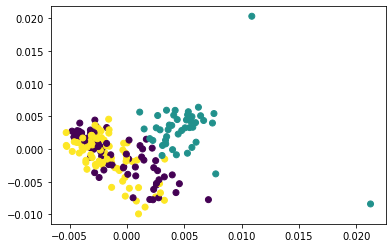

In [23]:
from sklearn.manifold import spectral_embedding
from sklearn.cluster import k_means
from matplotlib import pyplot as plt

emb = spectral_embedding(affinity)
centroid, label, _ = k_means(emb, 3)
plt.scatter(emb[:, 0], emb[:, 1], c=label)

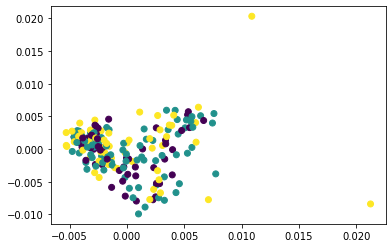

In [24]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(sample_species)
plt.scatter(emb[:, 0], emb[:, 1], c=le.transform(sample_species))

What is this? It's distributed like noise against the manifold with no real reason or rhyme?

## Try comparisons against a known set of points

In [72]:
import pandas as pd
df = pd.DataFrame(zip(species, data, audio), columns=["species", "data", "audio"])
df.head()

,species,data,audio
0,acafly,"[[0.3756666878584689, 0.37259816530431233, 0.3...",../data/motif/train_short_audio/acafly/XC10960...
1,acafly,"[[0.3526420750609852, 0.35178527616127747, 0.3...",../data/motif/train_short_audio/acafly/XC10960...
2,acafly,"[[0.3247211285736167, 0.3227699842406104, 0.31...",../data/motif/train_short_audio/acafly/XC11209...
3,acafly,"[[0.322090386851785, 0.3195279306817608, 0.317...",../data/motif/train_short_audio/acafly/XC11209...
4,acafly,"[[0.28324403789352703, 0.2856009155957204, 0.2...",../data/motif/train_short_audio/acafly/XC12703...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34980/34980 [00:49<00:00, 702.09it/s]


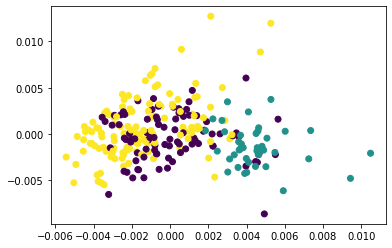

In [103]:
from sklearn.neighbors import NearestNeighbors

def compute_representative(df, k=3, plot=True):
    affinity = compute_affinity(df.data)
    # embed, create a nearest neighbor model
    emb = spectral_embedding(affinity)
    centroid, label, _ = k_means(emb, k)
    if plot:
        plt.scatter(emb[:,0], emb[:,1], c=label)
        plt.show()
    nn = NearestNeighbors().fit(emb)
    _, neighbors = nn.kneighbors(centroid)
    return neighbors[:, 0]

acafly = df[df.species == "acafly"]
acafly_idx = compute_representative(acafly)

In [74]:
for idx in acafly_idx:
    path = acafly.iloc[idx].audio
    print(path)
    ipd.display(ipd.Audio(path))

../data/motif/train_short_audio/acafly/XC135020/motif.1.ogg


../data/motif/train_short_audio/acafly/XC265805/motif.0.ogg


../data/motif/train_short_audio/acafly/XC517939/motif.0.ogg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72390/72390 [01:42<00:00, 703.96it/s]


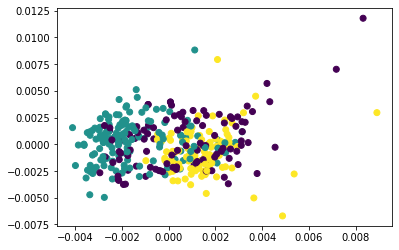

In [75]:
acowoo = df[df.species == "acowoo"].reset_index()
acowoo_idx = compute_representative(acowoo)

In [76]:
for idx in acowoo_idx:
    path = acowoo.iloc[idx].audio
    print(path)
    ipd.display(ipd.Audio(path))

../data/motif/train_short_audio/acowoo/XC565034/motif.0.ogg


../data/motif/train_short_audio/acowoo/XC206686/motif.1.ogg


../data/motif/train_short_audio/acowoo/XC448737/motif.1.ogg


  0%|▎                                                                                                                                                 | 67/34980 [00:00<00:52, 669.75it/s]

computing kmeans for acafly


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34980/34980 [00:50<00:00, 693.12it/s]


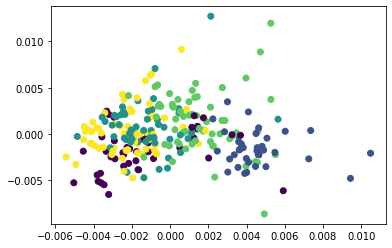

  0%|▏                                                                                                                                                 | 72/72390 [00:00<01:40, 719.90it/s]

computing kmeans for acowoo


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72390/72390 [01:43<00:00, 700.24it/s]


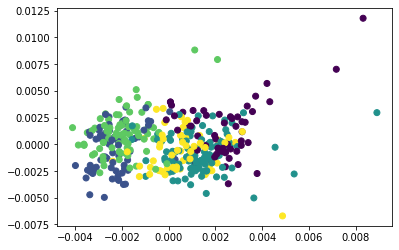

  0%|▏                                                                                                                                                 | 62/64261 [00:00<01:44, 613.87it/s]

computing kmeans for osprey


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64261/64261 [01:30<00:00, 713.14it/s]


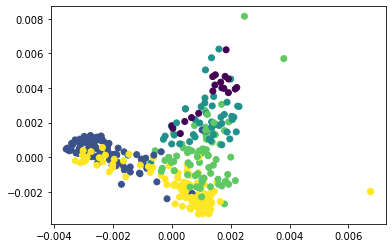

In [104]:
def compute_representative_set(df, k=3):
    res = []
    for species in df.species.unique():
        print(f"computing kmeans for {species}")
        sub = df[df.species == species].reset_index()
        idx = compute_representative(sub, k)
        res.append(sub.iloc[idx])
    return pd.concat(res).reset_index()

res = compute_representative_set(df, 5)

In [106]:
res

,level_0,index,species,data,audio
0,33,33,acafly,"[[0.37772466878958094, 0.3744591258756261, 0.3...",../data/motif/train_short_audio/acafly/XC13785...
1,234,234,acafly,"[[0.270425078896688, 0.2699585824258963, 0.269...",../data/motif/train_short_audio/acafly/XC51793...
2,96,96,acafly,"[[0.275196700647922, 0.27686766428778864, 0.27...",../data/motif/train_short_audio/acafly/XC26580...
3,149,149,acafly,"[[0.24817278810816995, 0.24771718776095666, 0....",../data/motif/train_short_audio/acafly/XC34032...
4,71,71,acafly,"[[0.2511987898309525, 0.2510075681420292, 0.25...",../data/motif/train_short_audio/acafly/XC24727...
5,332,596,acowoo,"[[0.3110839467976019, 0.3084674365531538, 0.30...",../data/motif/train_short_audio/acowoo/XC54057...
6,117,381,acowoo,"[[0.3019148304438637, 0.30351275056605603, 0.3...",../data/motif/train_short_audio/acowoo/XC27957...
7,237,501,acowoo,"[[0.3097715205513207, 0.30660637483443764, 0.3...",../data/motif/train_short_audio/acowoo/XC44873...
8,118,382,acowoo,"[[0.28666835878982, 0.2868329998850606, 0.2869...",../data/motif/train_short_audio/acowoo/XC28222...
9,353,617,acowoo,"[[0.24080942530040136, 0.23884924008435995, 0....",../data/motif/train_short_audio/acowoo/XC58264...


In [107]:
def compute_similarity(data, query, window=25):
    n = len(data)
    m = len(query)
    affinity = np.zeros((n, m))

    args = []
    for i in range(n):
        for j in range(m):
            args.append((i, j))

    for i, j in tqdm(args):
        mp, _ = simple_fast(data[i], query[j], window)
        val = np.median(mp)
        affinity[i][j] = val
    return affinity

In [108]:
sim = compute_similarity(df.data.values, res.data.values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15030/15030 [00:20<00:00, 720.16it/s]


In [109]:
sim.shape

(1002, 15)

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = sim
y = le.transform(df.species)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

clf = LogisticRegression(max_iter=500).fit(X_train, y_train)
clf.score(X_test, y_test)

0.4527363184079602

In [111]:
from sklearn.linear_model import RidgeClassifierCV

clf = RidgeClassifierCV().fit(X_train, y_train)
clf.score(X_test, y_test)

0.43283582089552236

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.40298507462686567